In [1]:
import sys
sys.path.append('../src')

In [2]:
import common.config as cfg
from common.nb_utils import estimate_optimal_ncomponents, pca_transform
from common.utils import get_device, Struct
from data.loader import get_testloader, get_trainloader
import matplotlib.pyplot as plt
from models.fcn import FCN
from models.resnet import resnet18
from models.model_op import get_random_grads, gradient_approximation
from models.svm import SVM
import models.resnet as resnet
import numpy as np
import pickle as pkl
import torch as t
import time
from tqdm.notebook import tqdm

In [3]:
dataset = 'cifar'
input_size = cfg.input_sizes[dataset]
output_size = cfg.output_sizes[dataset]
lr = 1e-1
sdirs_algo = 'pca' # 'qr'
bs = 16
epochs = 20

In [6]:
device = t.device('cuda:1')
loss = t.nn.CrossEntropyLoss().to(device)

In [7]:
trainloader = get_trainloader(dataset, bs, True)
testloader = get_testloader(dataset, bs, True)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
sdirs = []
m = 6
n_accum = m*50
for idx in tqdm(range(n_accum)):
    model = resnet.resnet18(num_channels=3, num_classes=output_size).to(device)
    sdirs.append(get_random_grads(model, np.sqrt(n_accum), device))

# pretraining

In [12]:
trainloader = get_trainloader(dataset, 256, False)
testloader = get_testloader(dataset, 256, False)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
model = resnet.resnet18(num_channels=3, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

correcti = 0
x_test = 0
for idx, (data, labels) in enumerate(testloader):
    x, y = data.to(device), labels.to(device)
    y_hat = model(x)
    loss_val = loss(y_hat, y)
    predi = y_hat.argmax(1, keepdim=True)
    correcti += predi.eq(y.view_as(predi)).sum().item()
y_test = correcti/len(testloader.dataset)
x_test, y_test

(0, 0.0805)

# w/o gradient approximation

In [14]:
model = resnet.resnet18(num_channels=3, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xb_train, yb_train = [], []
xb_test, yb_test =[], []
for _ in tqdm(range(1, epochs+1), leave=False):
    xb_train.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yb_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yb_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xb_train[-1], loss_val.item(), yb_train[-1], yb_test[-1]
    ))

1 	 1.7847 	 0.41 	 0.43
2 	 2.1442 	 0.58 	 0.54
3 	 1.1766 	 0.66 	 0.58
4 	 1.7179 	 0.72 	 0.60
5 	 2.0080 	 0.78 	 0.61
6 	 1.5175 	 0.82 	 0.64
7 	 1.2597 	 0.85 	 0.63
8 	 1.7308 	 0.88 	 0.63
9 	 0.8485 	 0.91 	 0.63
10 	 0.7528 	 0.92 	 0.64
11 	 1.1417 	 0.94 	 0.66
12 	 1.5007 	 0.95 	 0.67
13 	 2.0343 	 0.96 	 0.67
14 	 1.4824 	 0.97 	 0.67
15 	 0.7608 	 0.97 	 0.67
16 	 1.0551 	 0.98 	 0.68
17 	 1.8604 	 0.98 	 0.68
18 	 1.7758 	 0.98 	 0.67
19 	 2.0077 	 0.98 	 0.68
20 	 1.5410 	 0.99 	 0.69


# gradient approximation using n directions

In [15]:
n = 1
model = resnet.resnet18(num_channels=3, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xe_train, ye_train = [], []
xe_test, ye_test = [], []
for _ in tqdm(range(1, epochs+1), leave=False):
    start = time.time()
    xe_train.append(_)
    xe_test.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        _, error = gradient_approximation(
            model, 
            [sdirs[idx]], device, [])
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    ye_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    ye_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xe_train[-1], loss_val.item(), ye_train[-1], ye_test[-1]
    ))

1 	 2.6932 	 0.08 	 0.08
2 	 2.6515 	 0.08 	 0.09
3 	 2.6595 	 0.09 	 0.10
4 	 2.6927 	 0.09 	 0.10
5 	 2.6679 	 0.10 	 0.10
6 	 2.6270 	 0.10 	 0.10
7 	 2.5472 	 0.11 	 0.10
8 	 2.4857 	 0.11 	 0.11
9 	 2.4657 	 0.11 	 0.11
10 	 2.4811 	 0.11 	 0.12
11 	 2.5679 	 0.12 	 0.12
12 	 2.5658 	 0.12 	 0.12
13 	 2.5416 	 0.12 	 0.12
14 	 2.5597 	 0.12 	 0.12
15 	 2.5170 	 0.12 	 0.12
16 	 2.5571 	 0.12 	 0.12
17 	 2.5860 	 0.13 	 0.13
18 	 2.5824 	 0.13 	 0.13
19 	 2.5382 	 0.13 	 0.13
20 	 2.4953 	 0.13 	 0.13


In [16]:
n = 10
model = resnet.resnet18(num_channels=3, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xc_train, yc_train = [], []
xc_test, yc_test = [], []
for _ in tqdm(range(1, epochs+1), leave=False):
    start = time.time()
    xc_train.append(_)
    xc_test.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        _, error = gradient_approximation(
            model, 
            sdirs[idx:idx+n], device, [])
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yc_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yc_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xc_train[-1], loss_val.item(), yc_train[-1], yc_test[-1]
    ))

1 	 2.5078 	 0.09 	 0.11
2 	 2.5327 	 0.11 	 0.13
3 	 2.4441 	 0.13 	 0.14
4 	 2.3901 	 0.15 	 0.15
5 	 2.4031 	 0.16 	 0.16
6 	 2.4743 	 0.17 	 0.17
7 	 2.5807 	 0.18 	 0.18
8 	 2.6554 	 0.18 	 0.19
9 	 2.6849 	 0.19 	 0.20
10 	 2.4819 	 0.20 	 0.20
11 	 2.4057 	 0.20 	 0.20
12 	 2.2914 	 0.20 	 0.21
13 	 2.2633 	 0.21 	 0.21
14 	 2.3378 	 0.21 	 0.21
15 	 2.3900 	 0.21 	 0.22
16 	 2.0908 	 0.21 	 0.22
17 	 2.0557 	 0.22 	 0.22
18 	 1.9749 	 0.22 	 0.22
19 	 1.8400 	 0.22 	 0.23
20 	 1.9371 	 0.23 	 0.22


In [ ]:
n = 100
model = resnet.resnet18(num_channels=3, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xd_train, yd_train = [], []
xd_test, yd_test = [], []
for _ in tqdm(range(1, epochs+1), leave=False):
    start = time.time()
    xd_train.append(_)
    xd_test.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        _, error = gradient_approximation(
            model, 
            sdirs[idx: idx+n], device, [])
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yd_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yd_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xd_train[-1], loss_val.item(), yd_train[-1], yd_test[-1]
    ))

1 	 2.3007 	 0.15 	 0.19
2 	 2.2820 	 0.22 	 0.24


clf_resnet18_cifar_algo_pca_bs_16_sgd_vs_sgd_approx_random_proj_sampling


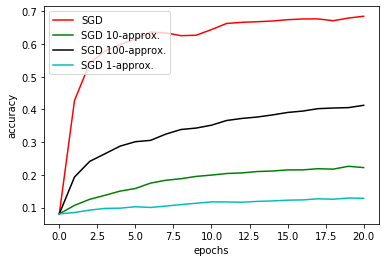

In [18]:
plt.figure()
plt.plot([x_test]+xb_train, [y_test]+yb_test, label='SGD', c='r')
# plt.plot([x_test]+xa_train, [y_test]+ya_test, label='SGD {}-approx.'.format(len(sdirs)), c='b')
plt.plot([x_test]+xc_train, [y_test]+yc_test, label='SGD 10-approx.', c='g')
plt.plot([x_test]+xd_train, [y_test]+yd_test, label='SGD 100-approx.', c='k')
plt.plot([x_test]+xe_train, [y_test]+ye_test, label='SGD 1-approx.', c='c')

history = {
    'test': [x_test, y_test],
#     'a': [xa_train, ya_train, xa_test, ya_test],
    'b': [xb_train, yb_train, xb_test, yb_test],
    'c': [xc_train, yc_train, xc_test, yc_test],
    'd': [xd_train, yd_train, xd_test, yd_test],
    'e': [xe_train, ye_train, xe_test, ye_test],
}

name = 'clf_{}_{}_algo_{}_bs_{}_sgd_vs_sgd_approx_random_proj_sampling'.format(
    'resnet18', dataset, sdirs_algo, bs)
print(name)

pkl.dump(history, open('../ckpts/history/{}.pkl'.format(name), 'wb'))

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig(
    '../ckpts/plots/{}.png'.format(name), 
    dpi=300, bbox_inches='tight'
)

# Comparisons

clf_resnet18_cifar_algo_pca_bs_16_sgd_vs_sgd_approx_comparison


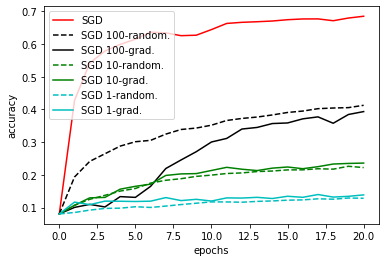

In [19]:
name = 'clf_{}_{}_algo_{}_bs_{}_sgd_vs_sgd_approx_random_proj_sampling'.format(
    'resnet18', dataset, sdirs_algo, bs)

history = pkl.load(open('../ckpts/history/{}.pkl'.format(name), 'rb'))
h = pkl.load(open('../ckpts/history/{}.pkl'.format(name.replace('proj', 'grad')), 'rb'))

plt.figure()
plt.plot([x_test]+xb_train, [y_test]+yb_test, label='SGD', c='r')
plt.plot([history['test'][0]]+history['d'][0], [history['test'][1]]+history['d'][-1], 
         label='SGD 100-random.', c='k', linestyle='--')
plt.plot([h['test'][0]]+h['d'][0], [h['test'][1]]+h['d'][-1], label='SGD 100-grad.', c='k')
plt.plot([history['test'][0]]+history['c'][0], [history['test'][1]]+history['c'][-1], 
         label='SGD 10-random.', c='g', linestyle='--')
plt.plot([h['test'][0]]+h['c'][0], [h['test'][1]]+h['c'][-1], label='SGD 10-grad.', c='g')
plt.plot([history['test'][0]]+history['e'][0], [history['test'][1]]+history['e'][-1], 
         label='SGD 1-random.', c='c', linestyle='--')
plt.plot([h['test'][0]]+h['e'][0], [h['test'][1]]+h['e'][-1], label='SGD 1-grad.', c='c')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
cname = 'clf_{}_{}_algo_{}_bs_{}_sgd_vs_sgd_approx_comparison'.format(
    'resnet18', dataset, sdirs_algo, bs)
print(cname)
plt.savefig(
    '../ckpts/plots/{}.png'.format(cname), 
    dpi=300, bbox_inches='tight'
)